In [ ]:
#Autoregrerssive models
#ACF plot and PACF plot

In [ ]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_absolute_error
import pytz

#importing plt acf and plot pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf#
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
#defining wrangle function to read the csv and then return a series Y
def wrangle(filename):
  #reading the data
  df = pd.read_csv(filename, index_col="timestamp")

  #changing index to datetime
  df.index = pd.to_datetime(df.index)

  #localizing the index timezone
  df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

  #removing outliers
  mask = df["P2"].between(0,500)
  df = df[mask]

  #resampling to 1 hr windows
  y = df["P2"].resample("1h").mean().fillna(method = "ffill")

  return y

In [ ]:
y = wrangle("/content/drive/MyDrive/Data for WQU/Project 3/WQU_project3Lesson2.csv")
y.shape

/tmp/ipython-input-1970228960.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df["P2"].resample("1h").mean().fillna(method = "ffill")


(2928,)

In [ ]:
y.head()

,P2
timestamp,
2018-09-01 03:00:00+03:00,17.541667
2018-09-01 04:00:00+03:00,15.800000
2018-09-01 05:00:00+03:00,11.420000
2018-09-01 06:00:00+03:00,11.614167
2018-09-01 07:00:00+03:00,17.665000


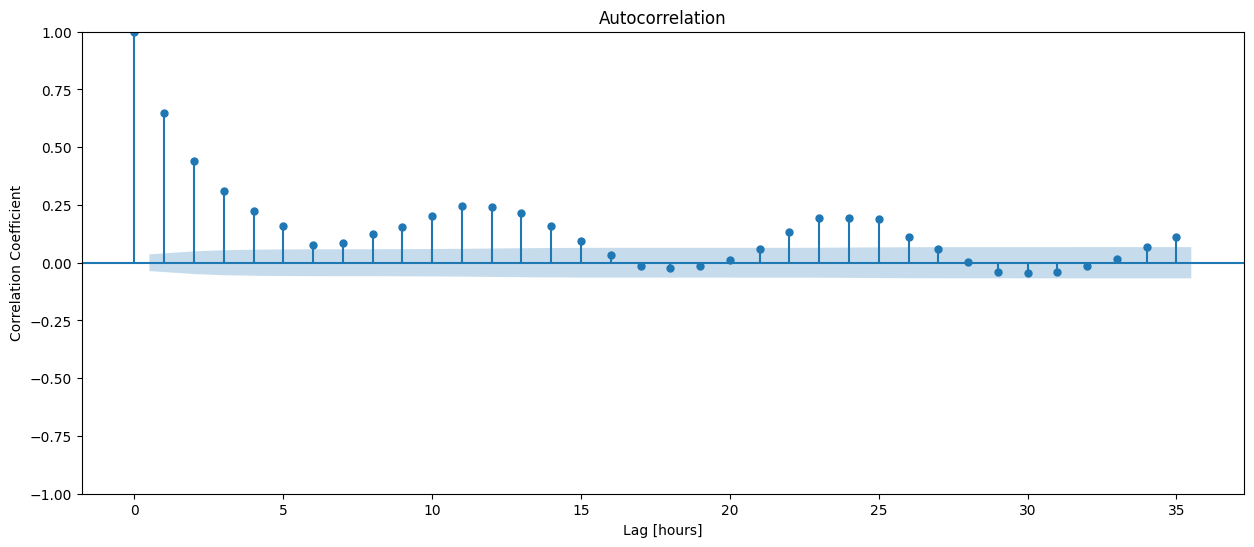

In [ ]:
#exploring the data using the ACF plot
#why do we need an ACF plot

fig, ax = plt.subplots(figsize= (15,6))
plot_acf(y, ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

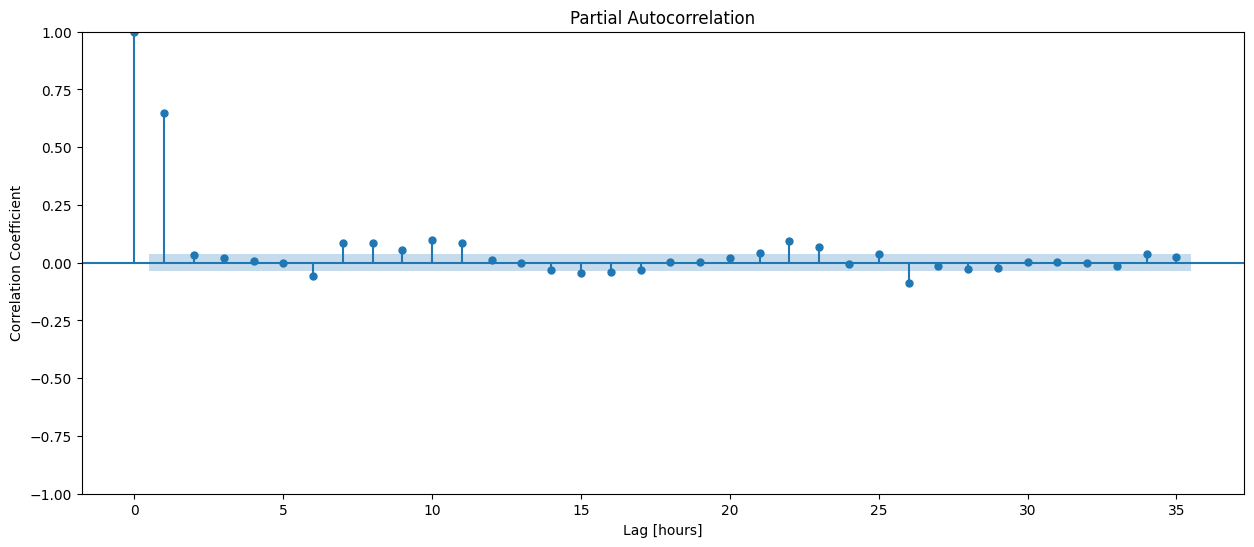

In [ ]:
fig, ax = plt.subplots(figsize= (15,6))
plot_pacf(y, ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [ ]:
#here we do not have a data frame so we ned not do the vertical feature an target split only a horizontal train test spil will suffice
cutoff = int(len(y)*.95)
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]
print(y_train.shape)
print("Test data size: ",y_test.shape)

(2781,)
Test data size:  (147,)


In [ ]:
#creating baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = round(mean_absolute_error(y_train, y_pred_baseline),2)

print("MAE_Baseline:", mae_baseline)

MAE_Baseline: 3.71


In [ ]:
#we will use auto reg model with lag of 26. Training and fitting model
model = AutoReg(y_train, lags = 26).fit()
y_pred = model.predict().dropna()

y_pred[:10]

,0
timestamp,
2018-09-02 05:00:00+03:00,10.098662
2018-09-02 06:00:00+03:00,10.547230
2018-09-02 07:00:00+03:00,10.786825
2018-09-02 08:00:00+03:00,11.275389
2018-09-02 09:00:00+03:00,10.133974
2018-09-02 10:00:00+03:00,15.556740
2018-09-02 11:00:00+03:00,9.123465
2018-09-02 12:00:00+03:00,7.649748
2018-09-02 13:00:00+03:00,8.849472


In [ ]:

training_mae = round(mean_absolute_error(y_train.iloc[26:],y_pred),2)
print("Training MAE:", training_mae)
print("Thus our model's training MAE beats the baseline MAE by",round(((mae_baseline-training_mae)/mae_baseline * 100),2),"%")

Training MAE: 2.28
Thus our model's training MAE beats the baseline MAE by 38.54 %


In [ ]:
y_train_resid = model.resid#can be used from stasts models to calculate the residuals
y_train_resid.head()

,0
timestamp,
2018-09-02 05:00:00+03:00,-1.756162
2018-09-02 06:00:00+03:00,-3.694730
2018-09-02 07:00:00+03:00,-3.540992
2018-09-02 08:00:00+03:00,-3.006223
2018-09-02 09:00:00+03:00,9.816860


<Axes: xlabel='timestamp', ylabel='residual values'>

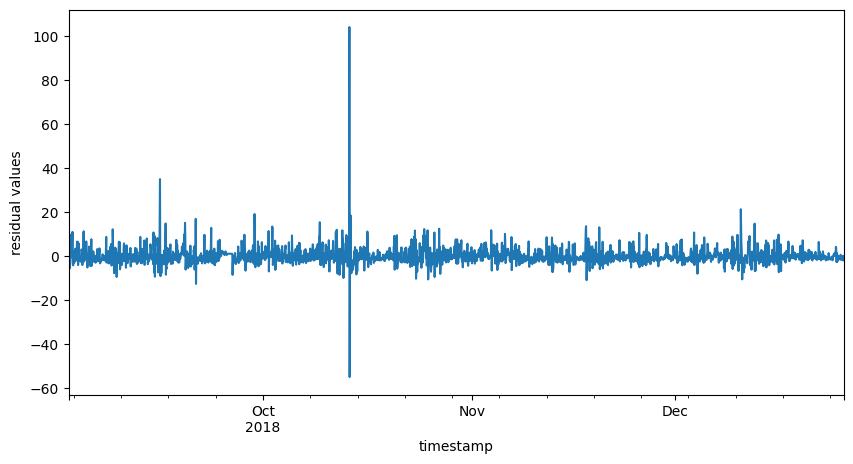

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
y_train_resid.plot(kind = "line", ylabel ="residual values")

Text(0.5, 1.0, 'Distribution of residuals')

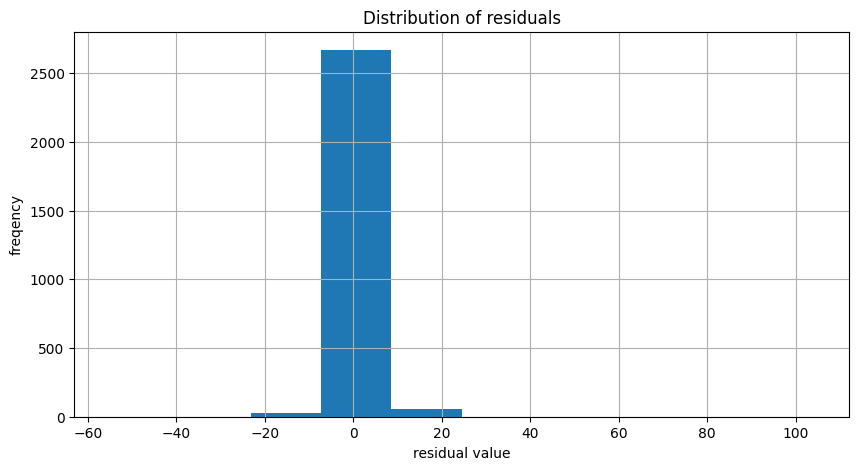

In [ ]:
# histogram
from scipy.stats import norm
mu, std = norm.fit(y_train_resid)

fig, ax = plt.subplots(figsize = (10,5))
y_train_resid.hist()



plt.xlabel("residual value")
plt.ylabel("freqency")
plt.title("Distribution of residuals")



<Axes: ylabel='Count'>

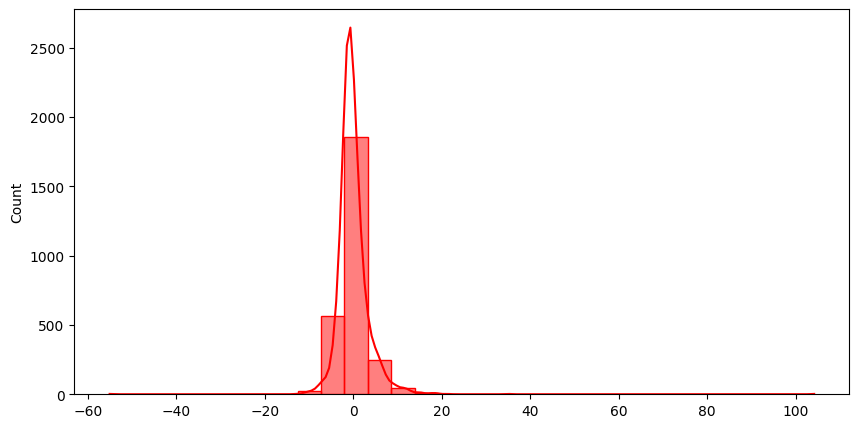

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,5))
sns.histplot(y_train_resid, bins=30, kde=True, color='red', edgecolor='red', ax=ax)

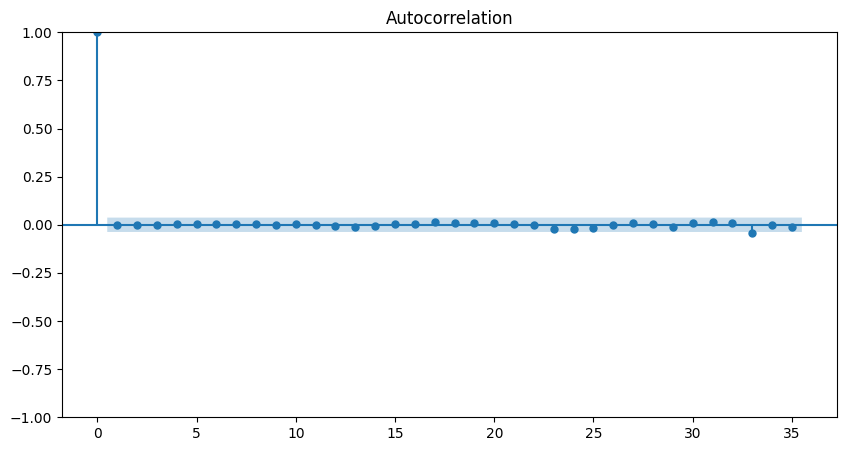

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
plot_acf(y_train_resid, ax=ax);

In [ ]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
mae_test = round(mean_absolute_error(y_test, y_pred_test),2)
print("Test MAE:", mae_test)

Test MAE: 3.01


In [ ]:
#creating a dictionary of train and test variables
df_pred_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred_test
}, index=y_test.index)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2018-12-26 00:00:00+03:00,5.679091,6.717606
2018-12-26 01:00:00+03:00,5.362500,7.259274
2018-12-26 02:00:00+03:00,4.786667,7.311588
2018-12-26 03:00:00+03:00,4.956667,7.551141
2018-12-26 04:00:00+03:00,5.055833,7.744001


In [ ]:
fig = px.line(df_pred_test, labels ={"values":"p2"})
fig.show()

In [ ]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags =26).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred]) # Use pd.concat instead of append
    history = pd.concat([history, y_test[next_pred.index]]) # Use pd.concat instead of append

In [ ]:
test_mae = round(mean_absolute_error(y_test, y_pred_wfv),2)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.4


In [ ]:
#Printing the model coefficients
print(model.params)

const     2.011432
P2.L1     0.587118
P2.L2     0.019796
P2.L3     0.023615
P2.L4     0.027187
P2.L5     0.044014
P2.L6    -0.102128
P2.L7     0.029583
P2.L8     0.049867
P2.L9    -0.016897
P2.L10    0.032438
P2.L11    0.064360
P2.L12    0.005987
P2.L13    0.018375
P2.L14   -0.007636
P2.L15   -0.016075
P2.L16   -0.015953
P2.L17   -0.035444
P2.L18    0.000756
P2.L19   -0.003907
P2.L20   -0.020655
P2.L21   -0.012578
P2.L22    0.052499
P2.L23    0.074229
P2.L24   -0.023806
P2.L25    0.090577
P2.L26   -0.088323
dtype: float64


In [ ]:
#plotting  the wfv plot

df_wfv = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred_wfv": y_pred_wfv
    }
)
print("First 5 predictions vs the real test set",df_wfv.head())
fig = px.line(df_wfv, labels = {"values":"P2.5"})
fig.show()

First 5 predictions vs the real test set                              y_test  y_pred_wfv
2018-12-26 00:00:00+03:00  5.679091    6.717606
2018-12-26 01:00:00+03:00  5.362500    6.652194
2018-12-26 02:00:00+03:00  4.786667    6.180631
2018-12-26 03:00:00+03:00  4.956667    6.010500
2018-12-26 04:00:00+03:00  5.055833    6.102229
